# Demo: sampling from Huggingface's CIFAR10 DDPM, but after fine-tuning it with ITdiffusion

### Imports and setup

In [1]:
import time
import numpy as np
import math
import tqdm
from tqdm import trange
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
!pip install diffusers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.8/934.8 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 9.1 MB/s eta 0:00:00


### Get fine-tuned model's pytorch checkpoint (saved on my google drive)

In [3]:
# Huggingface hub directory from which we get the pre-trained CIFAR10 DDPM model's config 
model_id = "google/ddpm-cifar10-32"

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
!ls drive/MyDrive/density_estimation/checkpoints/ddpm

model_epoch10.pt


In [6]:
import os

In [7]:
dir_ddpm_fine_tuned_pt = "drive/MyDrive/density_estimation/checkpoints/ddpm/"
path_ddpm_fine_tuned_pt = os.path.join(dir_ddpm_fine_tuned_pt, "model_epoch10.pt")

In [8]:
!stat $path_ddpm_fine_tuned_pt

  File: drive/MyDrive/density_estimation/checkpoints/ddpm/model_epoch10.pt
  Size: 143106097 	Blocks: 279505     IO Block: 65536  regular file
Device: 2ah/42d	Inode: 505         Links: 1
Access: (0600/-rw-------)  Uid: (    0/    root)   Gid: (    0/    root)
Access: 2023-04-27 03:31:59.000000000 +0000
Modify: 2023-04-27 03:27:04.000000000 +0000
Change: 2023-04-27 03:31:59.000000000 +0000
 Birth: -


### Utils for displaying samples

In [9]:
import PIL.Image
import numpy as np

def display_sample(sample, i, custom_figsize=None):
    image_processed = sample.cpu().permute(0, 2, 3, 1)
    image_processed = (image_processed + 1.0) * 127.5
    image_processed = image_processed.numpy().astype(np.uint8)

    image_pil = PIL.Image.fromarray(image_processed[0])

    display(f"Image at step {i}")

    if custom_figsize:
        plt.figure(figsize=custom_figsize)
        plt.imshow(image_pil)

    else:
        display(image_pil)    

## Sample from CIFAR10 DDPM fine-tuned with ITdiffusion
The model here is the result of using ITdiffusion to fine-tune the original CIFAR10 DDPM (from Huggingface, pre-trained)

### Extra
ITdiffusion's wrapper for huggingface's UNet2DModel, to be compatible with their ITdiffusion implementation for fine-tuning

In [10]:
# class WrapUNet2DModel(UNet2DModel):
#     """Wrap UNet2DModel to accept arguments compatible with Diffusion Model."""
#     def __init__(self, *args, **kwargs):
#         super().__init__(*args, **kwargs)

#     def forward(self, z, snr):
#         x = z[0]
#         timestep = self.logsnr2t(torch.log(snr))
#         eps_hat = super().forward(x, timestep).sample
#         return eps_hat

#     def logsnr2t(self, logsnr):
#         num_diffusion_steps = 10000 # improve the timestep precision
#         alphas_cumprod = torch.sigmoid(logsnr)
#         scale = 1000 / num_diffusion_steps
#         beta_start = scale * 0.0001
#         beta_end = scale * 0.02
#         betas = np.linspace(beta_start, beta_end, num_diffusion_steps, dtype=np.float64)
#         alphas = 1.0 - betas
#         alphabarGT = torch.tensor(np.cumprod(alphas, axis=0), device=alphas_cumprod.device)
#         timestep = torch.argmin(abs(alphabarGT-alphas_cumprod.unsqueeze(1)), dim=1) * scale
#         return timestep

### Set up model

In [11]:
import torch
# import torch.nn as nn
# import torch.nn.functional as F

from diffusers import UNet2DModel

In [12]:
checkpoint = torch.load(path_ddpm_fine_tuned_pt)

Load model config from hub for pre-trained cifar10 ddpm, but use state dict (weights) from the model after fine-tuning with ITdiffusion

In [13]:
model = UNet2DModel.from_pretrained(model_id) # was originally called modelB in ITdiffusion implementation bc they want to wrap it
# model = WrapUNet2DModel(**modelB.config)
# model.load_state_dict(modelB.state_dict())
model.load_state_dict(checkpoint)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


<All keys matched successfully>

In [14]:
# model

In [15]:
# model.config

In [16]:
model.save_pretrained("my_model")

In [17]:
!ls my_model

config.json  diffusion_pytorch_model.bin


In [18]:
# model = UNet2DModel.from_pretrained("my_model")

### Set up scheduler

In [19]:
from diffusers import DDPMScheduler, DDIMScheduler

scheduler = DDPMScheduler.from_config(model_id)
# scheduler = DDIMScheduler.from_config(model_id)

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:215: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


In [20]:
# scheduler.set_timesteps(num_inference_steps=50)

In [21]:
scheduler.config

FrozenDict([('num_train_timesteps', 1000),
            ('beta_start', 0.0001),
            ('beta_end', 0.02),
            ('beta_schedule', 'linear'),
            ('trained_betas', None),
            ('variance_type', 'fixed_large'),
            ('clip_sample', True),
            ('prediction_type', 'epsilon'),
            ('thresholding', False),
            ('dynamic_thresholding_ratio', 0.995),
            ('clip_sample_range', 1.0),
            ('sample_max_value', 1.0),
            ('_class_name', 'DDPMScheduler'),
            ('_diffusers_version', '0.1.1')])

In [22]:
# scheduler.timesteps

In [23]:
scheduler.save_config("my_scheduler")
# new_scheduler = DDPMScheduler.from_config("my_scheduler")

### Set up sampling

### Generate samples

In [24]:
torch.manual_seed(0)

samples = []

def generate_sample(model, scheduler, n_samples_gen=1):
    noisy_sample = torch.randn(
        n_samples_gen, model.config.in_channels, model.config.sample_size, model.config.sample_size
    )

    with torch.no_grad():
        noisy_residual = model(sample=noisy_sample, timestep=2).sample

    less_noisy_sample = scheduler.step(
        model_output=noisy_residual, timestep=2, sample=noisy_sample
    ).prev_sample

    model.to("cuda")
    noisy_sample = noisy_sample.to("cuda")

    sample = noisy_sample

    for i, t in enumerate(tqdm.tqdm(scheduler.timesteps)):
      # 1. predict noise residual
      with torch.no_grad():
          residual = model(sample, t).sample

      # 2. compute less noisy image and set x_t -> x_t-1
      sample = scheduler.step(residual, t, sample).prev_sample

      # # 3. optionally look at image
      # if (i + 1) % 10 == 0:
      #     display_sample(sample, i + 1)
    return sample

In [25]:
%%time
gen_sample_batch = generate_sample(model, scheduler, n_samples_gen=400)

100%|██████████| 1000/1000 [16:17<00:00,  1.02it/s]

CPU times: user 17min 35s, sys: 20.7 s, total: 17min 55s
Wall time: 18min 10s


In [30]:
!mkdir generated_images

In [37]:
np.savez("generated_images/gen_cifar10_fine_tuned.npz", gen_sample_batch.cpu().numpy())

In [42]:
gen_sample_batch.shape

torch.Size([400, 3, 32, 32])

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:135: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


'Image at step 1000'

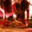

In [39]:
display_sample(gen_sample_batch[5:6,], scheduler.num_train_timesteps)

In [67]:
def display_images_grid(images, grid_shape):
    n, _, w, h = images.shape
    n_rows = w * grid_shape[0]
    n_cols = h * grid_shape[1]

    assert n >= grid_shape[0] * grid_shape[1], "you have fewer images than grid spaces!"

    new_im = PIL.Image.new('RGB', (n_rows, n_cols))

    idx = 0
    for i in range(0, n_rows, w):
        for j in range(0, n_cols, h):
            image_processed = images[idx:idx+1].cpu().permute(0, 2, 3, 1)
            image_processed = (image_processed + 1.0) * 127.5
            image_processed = image_processed.numpy().astype(np.uint8)
            im=PIL.Image.fromarray(image_processed[0])
            #paste the image at location i,j:
            new_im.paste(im, (i,j))
            idx += 1

    new_im.show()

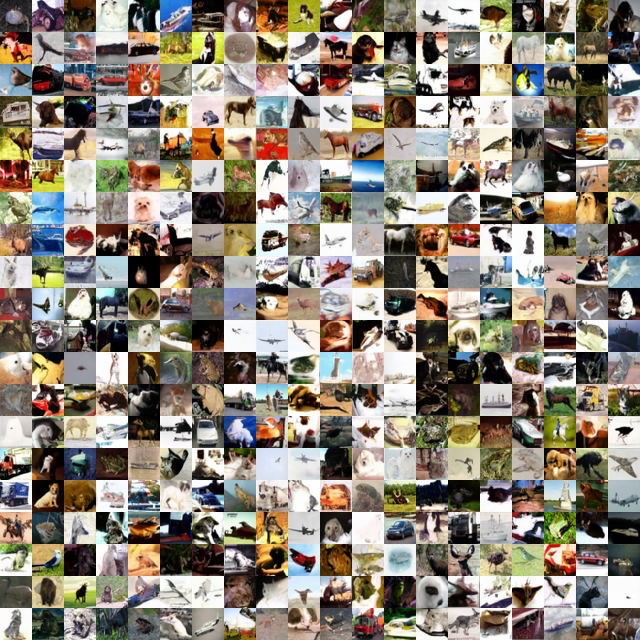

In [44]:
display_images_grid(gen_sample_batch, (20, 20))

In [45]:
# image_processed = sample.cpu().permute(0, 2, 3, 1)
# image_processed = (image_processed + 1.0) * 127.5
# image_processed = image_processed.numpy().astype(np.uint8)

# image_pil = PIL.Image.fromarray(image_processed[0])
# plt.figure(figsize=(5,5))   
# plt.imshow(image_pil)

## Sample from original CIFAR10 DDPM (from Huggingface, pre-trained)

In [46]:
model_id

'google/ddpm-cifar10-32'

### Set up model pipeline

In [47]:
# # !pip install diffusers
# from diffusers import DDPMPipeline, DDIMPipeline, PNDMPipeline

In [48]:
# # load model and scheduler
# ddpm_pretrained = DDPMPipeline.from_pretrained(model_id)  # you can replace DDPMPipeline with DDIMPipeline or PNDMPipeline for faster inference

In [49]:
# ddpm_pretrained

### Generate samples

In [50]:
model_ddpm_pretrained = UNet2DModel.from_pretrained(model_id)
scheduler_ddpm_pretrained = DDPMScheduler.from_config(model_id)
# scheduler_ddpm_pretrained = DDIMScheduler.from_config(model_id)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:215: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


In [51]:
# scheduler_ddpm_pretrained.set_timesteps(num_inference_steps=50)

In [64]:
# scheduler_ddpm_pretrained.config

In [65]:
# scheduler_ddpm_pretrained.timesteps

In [54]:
%%time
gen_sample_batch_ddpm_pretrained = generate_sample(model_ddpm_pretrained, scheduler_ddpm_pretrained, n_samples_gen=400)

100%|██████████| 1000/1000 [16:10<00:00,  1.03it/s]

CPU times: user 17min 29s, sys: 20.1 s, total: 17min 49s
Wall time: 17min 59s


/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:135: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


'Image at step 1000'

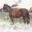

In [66]:
display_sample(gen_sample_batch_ddpm_pretrained[5:6,], scheduler.num_train_timesteps)

In [55]:
np.savez("generated_images/gen_cifar10_original.npz", gen_sample_batch_ddpm_pretrained.cpu().numpy())

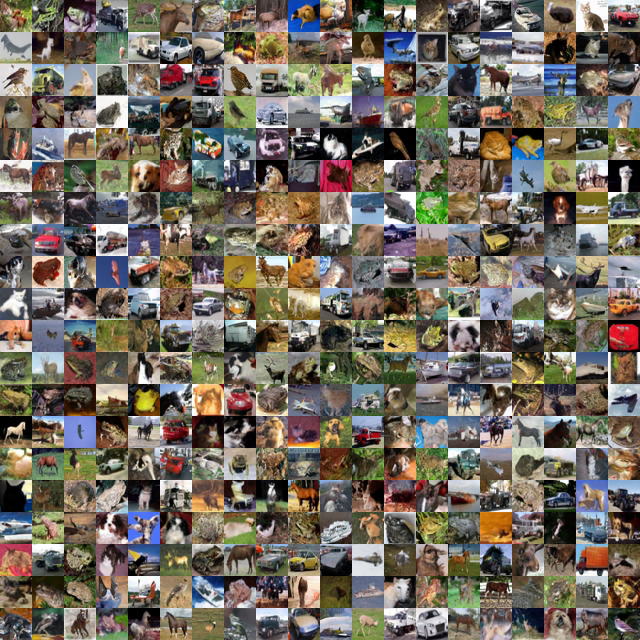

In [68]:
display_images_grid(gen_sample_batch_ddpm_pretrained, (20, 20))

### Extra

In [57]:
# image_processed = sample.cpu().permute(0, 2, 3, 1)
# image_processed = (image_processed + 1.0) * 127.5
# image_processed = image_processed.numpy().astype(np.uint8)

# image_pil = PIL.Image.fromarray(image_processed[0])
# plt.figure(figsize=(5,5))   
# plt.imshow(image_pil)

### Or, do it the fast way
Actually, this is much slower

In [58]:
# %%time
# # run pipeline in inference (sample random noise and denoise)
# generated_images = ddpm_pretrained().images

In [59]:
# generated_images

In [60]:
# image = generated_images[0]

In [61]:
# image

In [62]:
# # save image
# image.save("ddpm_generated_image.png")

In [63]:
# # import matplotlib.image as mpimg
# # img = mpimg.imread('your_image.png')
# plt.figure(figsize=(5,5))
# imgplot = plt.imshow(image)
# plt.show()

## FID Score
Implementation from https://github.com/mseitzer/pytorch-fid/blob/master/src/pytorch_fid/fid_score.py 